## Imports

In [112]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from scipy.spatial.distance import cdist

## Reading Data

In [113]:
CLASSES = ["flooded", "non-flooded"]
def load_data(data_path):
    data = []
    for c in CLASSES:
        path = os.path.join(data_path, c)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            img_array = cv2.resize(img_array, (512 , 512))
            data.append(img_array)
    return data

# Load data
data = load_data("./Dataset")

## Defining Colors

In [95]:
color_map = np.array([  
    (0, 0, 255), # blue
    (0, 0, 0), # black
    (255, 255, 0), # yellow
    (255, 0, 255), # magenta
    (0, 255, 255), # cyan
    (255, 255, 255), # white
    (255, 0, 0), # red
    (0, 255, 0), # green
    ]
)

## Kmeans Segmentation

In [114]:
def KMeans_segmentation(image):
    image = np.array(image, dtype=np.float64) / 255
    w, h, d = original_shape = tuple(image.shape)
    image_array = np.reshape(image, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0)
    n_clusters = 2
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(image_array_sample)
    labels = kmeans.predict(image_array)
    cluster_centers = kmeans.cluster_centers_
    labels = np.reshape(labels, (w, h))
    labels = color_map[labels]
    return labels


## ISODATA Segmentation

In [122]:
def isodata_segmentation(image, num_clusters, max_iterations, T, min_cluster_size):
    # Flatten the image into a 2D array
    height, width, num_channels = image.shape
    flattened_image = np.reshape(image, (height * width, num_channels))

    # Initialize the mean vectors (centers) using K-means++
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=1, n_init=1)
    kmeans.fit(flattened_image)
    centers = kmeans.cluster_centers_

    # Perform ISODATA iterations
    for iteration in range(max_iterations):
        # Assign each pixel to the closest cluster center
        distances = cdist(flattened_image, centers)
        labels = np.argmin(distances, axis=1)

        # Compute new mean vectors for each cluster
        for cluster_idx in range(num_clusters):
            cluster_pixels = flattened_image[labels == cluster_idx]
            if len(cluster_pixels) > 0:
                centers[cluster_idx] = np.mean(cluster_pixels, axis=0)

        # Perform ISODATA checks
        # if (iteration + 1) % 10 == 0:
        centers, num_clusters = check_cluster_size(centers, labels, min_cluster_size)
        centers, num_clusters = check_distance(centers, T)

        # Terminate if termination conditions are met
        if num_clusters <= 1 or iteration == max_iterations - 1:
            break

    # Assign labels to each pixel based on the final cluster centers
    distances = cdist(flattened_image, centers)
    labels = np.argmin(distances, axis=1)
    segmented_image = np.reshape(labels, (height, width))
    segmented_image = color_map[segmented_image]
    return segmented_image


def check_cluster_size(centers, labels, min_cluster_size):
    num_clusters = centers.shape[0]
    cluster_sizes = np.bincount(labels)
    valid_clusters = cluster_sizes >= min_cluster_size

    if np.sum(valid_clusters) == 0:
        # If no valid clusters remain, keep the largest cluster
        largest_cluster = np.argmax(cluster_sizes)
        centers = centers[largest_cluster]
        num_clusters = 1
    else:
        # Keep only the valid clusters
        centers = centers[valid_clusters]
        num_clusters = np.sum(valid_clusters)

    return centers, num_clusters


def check_distance(centers, T):
    num_clusters = centers.shape[0]
    distances = cdist(centers, centers)
    np.fill_diagonal(distances, np.inf)

    merged_clusters = np.where(np.min(distances) < T)
    if merged_clusters[0].size > 0:
        merged_cluster_idx = merged_clusters[0][0]
        centers = np.delete(centers, merged_cluster_idx, axis=0)
        num_clusters -= 1

    return centers, num_clusters


## Testing

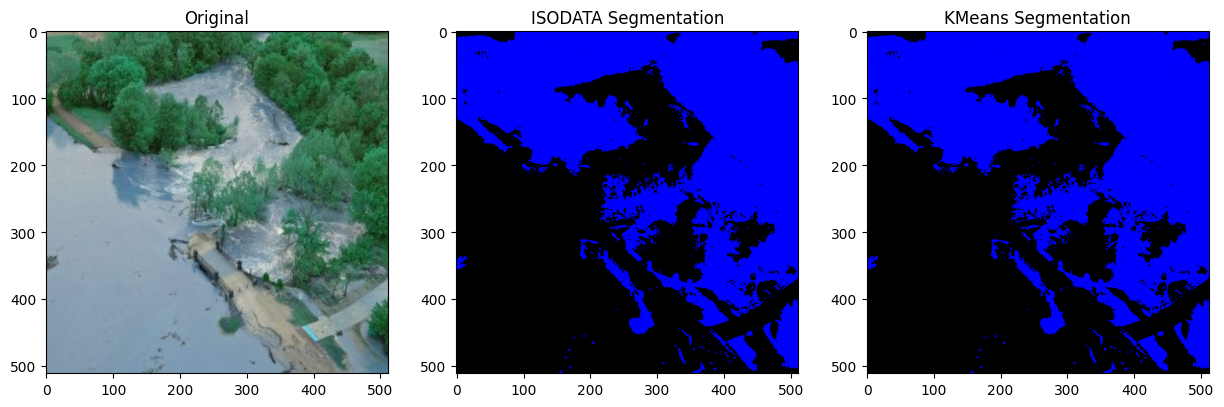

In [127]:

def segment_image(image_num):
    image = data[image_num]
    segment_image_ISO = isodata_segmentation(image, num_clusters=2 ,max_iterations=100, T=20, min_cluster_size=10)
    segment_image_KMeans = KMeans_segmentation(image)
    fig, axs = plt.subplots(1, 3 ,figsize=(15,15))
    axs[0].imshow(image)
    axs[0].set_title("Original")
    axs[1].imshow(segment_image_ISO)
    axs[1].set_title("ISODATA Segmentation")
    axs[2].imshow(segment_image_KMeans)
    axs[2].set_title("KMeans Segmentation")
    plt.show()

segment_image(79)
